<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#can-HTM-predict-crypto-prices?-probably" data-toc-modified-id="can-HTM-predict-crypto-prices?-probably-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>can HTM predict crypto prices? probably</a></span><ul class="toc-item"><li><span><a href="#can-i-use-HTM-to-do-so?-let's-find-out" data-toc-modified-id="can-i-use-HTM-to-do-so?-let's-find-out-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>can <em>i</em> use HTM to do so? let's find out</a></span></li><li><span><a href="#features:" data-toc-modified-id="features:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>features:</a></span></li><li><span><a href="#borrowing-some-defaults-from-hotgym.py-(htm.core-edition)" data-toc-modified-id="borrowing-some-defaults-from-hotgym.py-(htm.core-edition)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>borrowing some defaults from hotgym.py (htm.core edition)</a></span></li><li><span><a href="#dateTime-conversion:" data-toc-modified-id="dateTime-conversion:-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>dateTime conversion:</a></span></li></ul></li><li><span><a href="#encoders" data-toc-modified-id="encoders-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>encoders</a></span></li><li><span><a href="#spatial-pooler-+-TM-+-anomaly-setup" data-toc-modified-id="spatial-pooler-+-TM-+-anomaly-setup-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>spatial pooler + TM + anomaly setup</a></span></li><li><span><a href="#post-training-checks" data-toc-modified-id="post-training-checks-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>post-training checks</a></span><ul class="toc-item"><li><span><a href="#strange-realignment-function-(magic?)" data-toc-modified-id="strange-realignment-function-(magic?)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>strange realignment function (magic?)</a></span></li><li><span><a href="#create-function-to-investigate-smaller-time-span-of-predictions" data-toc-modified-id="create-function-to-investigate-smaller-time-span-of-predictions-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>create function to investigate smaller time-span of predictions</a></span></li></ul></li></ul></div>

In [2]:
import csv
import datetime
import os
import numpy as np
import random
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

from htm.bindings.sdr import SDR, Metrics
from htm.encoders.rdse import RDSE, RDSE_Parameters
from htm.encoders.date import DateEncoder
from htm.bindings.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
from htm.algorithms.anomaly_likelihood import AnomalyLikelihood #FIXME use TM.anomaly instead, but it gives worse results than the py.AnomalyLikelihood now
from htm.bindings.algorithms import Predictor

# can HTM predict crypto prices? probably
## can _i_ use HTM to do so? let's find out

In [9]:
df = pd.read_csv('coinbase_btc_hourly.csv')
df = df.rename(columns={'Volume BTC':'volume_btc',
                  'Symbol':'symbol',
                  'Open':'open',
                  'High':'high',
                  'Low':'low',
                  'Close':'close',
                  'Volume USD':'volume_usd',
                  'Date':'date'})

# convert date to dateTime format
df['date'] = df['date'].apply(lambda x: 
                             datetime.datetime.strptime(x, '%Y-%m-%d %I-%p'))
print(type(df.iloc[0]['date']))
df = df.sort_values(by='date')
df = df.reset_index(drop=True) # that fixed it. nice
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,date,symbol,open,high,low,close,volume_btc,volume_usd
0,2017-07-01 11:00:00,BTCUSD,2505.56,2513.38,2495.12,2509.17,114.60,287000.32
1,2017-07-01 12:00:00,BTCUSD,2509.17,2512.87,2484.99,2488.43,157.36,393142.50
2,2017-07-01 13:00:00,BTCUSD,2488.43,2488.43,2454.40,2454.43,280.28,693254.01
3,2017-07-01 14:00:00,BTCUSD,2454.43,2473.93,2450.83,2459.35,289.42,712864.80
4,2017-07-01 15:00:00,BTCUSD,2459.35,2475.00,2450.00,2467.83,276.82,682105.41


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27149 entries, 0 to 27148
Data columns (total 8 columns):
date          27149 non-null object
symbol        27149 non-null object
open          27149 non-null float64
high          27149 non-null float64
low           27149 non-null float64
close         27149 non-null float64
volume_btc    27149 non-null float64
volume_usd    27149 non-null float64
dtypes: float64(6), object(2)
memory usage: 1.7+ MB


## features:
- 6 scalars
    - is there a need to encode the ratio of volume_usd to volume_btc?
        - if we encode both in the SDR, probably not...
    - 6 scalars is surprisingly not that hard to encode! have to be careful about min/max, however
    - but it's easier than a graph, at least.

## borrowing some defaults from hotgym.py (htm.core edition)

In [10]:
parameters = {
  # there are 2 (3) encoders: "value" (RDSE) & "time" (DateTime weekend, timeOfDay)
 'enc': {
      "value" :
         {'resolution': 0.88, 'size': 700, 'sparsity': 0.02},
      "time": 
         {'timeOfDay': (30, 1), 'weekend': 21}
 },
 'predictor': {'sdrc_alpha': 0.1},
 'sp': {'boostStrength': 3.0,
        'columnCount': 1638,
        'localAreaDensity': 0.04395604395604396,
        'potentialPct': 0.85,
        'synPermActiveInc': 0.04,
        'synPermConnected': 0.13999999999999999,
        'synPermInactiveDec': 0.006},
 'tm': {'activationThreshold': 17,
        'cellsPerColumn': 13,
        'initialPerm': 0.21,
        'maxSegmentsPerCell': 128,
        'maxSynapsesPerSegment': 64,
        'minThreshold': 10,
        'newSynapseCount': 32,
        'permanenceDec': 0.1,
        'permanenceInc': 0.1},
 'anomaly': {
   'likelihood': 
       {#'learningPeriod': int(math.floor(self.probationaryPeriod / 2.0)),
        #'probationaryPeriod': self.probationaryPeriod-default_parameters["anomaly"]["likelihood"]["learningPeriod"],
        'probationaryPct': 0.1,
        'reestimationPeriod': 100} #These settings are copied from NAB
 }
}

## dateTime conversion:
- running strptime() with pandas lambda changes it into a Timestamp object, even parsing with the same format
- the dateTime encoder before used datetime.datetime(x,x,x,x,x) format. wonder if this pandas Timestamp will crash?
- let's find out
- blimey, it worked no worries
    - perhaps Timestamp is just a specialized object inheriting from datetime

# encoders
- we've got 6 scalars to encode...
    - but htm.core hasn't implemented a MultiEncoder like Nupic has
        - looking through nupic's github "encoders" directory, man they've got some cool encoders
        - geospatial encoders! makes me want to sort out the whole python=2.7 thing...
    - for now, we can just use the same scalarEncoder for each variable and have a bloody big concatenated SDR
    - i'm sure tuning individual encoders would be much better, but let's start with this

In [11]:
dateEncoder = DateEncoder(
    timeOfDay = parameters['enc']['time']['timeOfDay'], # (30,1)
    weekend = parameters["enc"]["time"]["weekend"]) # 21

scalarEncoderParams = RDSE_Parameters() # random distributed scalar encoder
scalarEncoderParams.size       = parameters["enc"]["value"]["size"] # 700
scalarEncoderParams.sparsity   = parameters["enc"]["value"]["sparsity"] # 0.02
scalarEncoderParams.resolution = parameters["enc"]["value"]["resolution"] # 0.88
scalarEncoder = RDSE(scalarEncoderParams) # create the encoder

encodingWidth = (dateEncoder.size + scalarEncoder.size*6) # since we're using the SEncoder 6 times
enc_info = Metrics( [encodingWidth], 999999999) # performance metrics storage obj

# spatial pooler + TM + anomaly setup

In [12]:
# spatial pooler
spParams = parameters['sp']
sp = SpatialPooler(
    inputDimensions            = (encodingWidth,),
    columnDimensions           = (spParams["columnCount"],),
    potentialPct               = spParams["potentialPct"],
    potentialRadius            = encodingWidth,
    globalInhibition           = True,
    localAreaDensity           = spParams["localAreaDensity"],
    synPermInactiveDec         = spParams["synPermInactiveDec"],
    synPermActiveInc           = spParams["synPermActiveInc"],
    synPermConnected           = spParams["synPermConnected"],
    boostStrength              = spParams["boostStrength"],
    wrapAround                 = True
)
sp_info = Metrics(sp.getColumnDimensions(), 999999999)
# temporal memory
tmParams = parameters['tm']
tm = TemporalMemory(
    columnDimensions          = (spParams["columnCount"],),
    cellsPerColumn            = tmParams["cellsPerColumn"], # 13
    activationThreshold       = tmParams["activationThreshold"], # 17
    initialPermanence         = tmParams["initialPerm"], # 0.21
    connectedPermanence       = spParams["synPermConnected"],
    minThreshold              = tmParams["minThreshold"], # 19
    maxNewSynapseCount        = tmParams["newSynapseCount"], # 32
    permanenceIncrement       = tmParams["permanenceInc"], # 0.1
    permanenceDecrement       = tmParams["permanenceDec"], # 0.1
    predictedSegmentDecrement = 0.0,
    maxSegmentsPerCell        = tmParams["maxSegmentsPerCell"], # 128
    maxSynapsesPerSegment     = tmParams["maxSynapsesPerSegment"] # 64
)
tm_info = Metrics( [tm.numberOfCells()], 999999999)

# anomaly prediction
anParams = parameters['anomaly']['likelihood']
probationaryPeriod = int(math.floor(float(anParams['probationaryPct'])*len(df)))
learningPeriod = int(math.floor(probationaryPeriod / 2.0))
anomaly_history = AnomalyLikelihood(learningPeriod = learningPeriod,
       estimationSamples = probationaryPeriod - learningPeriod,
       reestimationPeriod = anParams['reestimationPeriod'])
predictor = Predictor(steps=[1,5], alpha=parameters['predictor']['sdrc_alpha'])
predictor_resolution = 1 # divisor

In [13]:
# pre-training, no-infer loop:
print('pre-training...')
for i, row in tqdm(df.iterrows()):
    btc_price = row['close'] # desired output to predict
    
    date = dateEncoder.encode(row['date'])
    
    open_price = scalarEncoder.encode(row['open'])
    high = scalarEncoder.encode(row['high'])
    low = scalarEncoder.encode(row['low'])
    close_price = scalarEncoder.encode(row['close'])
    volume_btc = scalarEncoder.encode(row['volume_btc'])
    volume_usd = scalarEncoder.encode(row['volume_usd'])

    encodingWidth = date.size+open_price.size+high.size+low.size+close_price.size+volume_btc.size+volume_usd.size
    encoding = SDR(encodingWidth).concatenate([date, open_price, high, low, close_price,
                                              volume_btc, volume_usd])
    enc_info.addData(encoding)
    # encoding worked. not bad
    
    # spatial pool !
    activeColumns = SDR(sp.getColumnDimensions()) # for clarity
    sp.compute(encoding, True, activeColumns)
    
    # temporal memory
    tm_info.addData(tm.getActiveCells().flatten())
    tm.compute(activeColumns, learn=True)
    predictor.learn(i, tm.getActiveCells(), int(btc_price/predictor_resolution))

print('pre-training complete. training...')
# so the training loop is going to look something like:
inputs = []
anomaly = []
anomalyProb = []
predictions = {1: [], 5:[]}
leng = len(df)

predictor.reset()
for i, row in tqdm(df.iterrows()):
    btc_price = row['close'] # desired output to predict
    
    date = dateEncoder.encode(row['date'])
    
    open_price = scalarEncoder.encode(row['open'])
    high = scalarEncoder.encode(row['high'])
    low = scalarEncoder.encode(row['low'])
    close_price = scalarEncoder.encode(row['close'])
    volume_btc = scalarEncoder.encode(row['volume_btc'])
    volume_usd = scalarEncoder.encode(row['volume_usd'])

    encodingWidth = date.size+open_price.size+high.size+low.size+close_price.size+volume_btc.size+volume_usd.size
    encoding = SDR(encodingWidth).concatenate([date, open_price, high, low, close_price,
                                              volume_btc, volume_usd])
    enc_info.addData(encoding)
    # encoding worked. not bad
    
    # spatial pool !
    activeColumns = SDR(sp.getColumnDimensions()) # for clarity
    sp.compute(encoding, True, activeColumns)
    
    # temporal memory
    tm_info.addData(tm.getActiveCells().flatten())
    tm.compute(activeColumns, learn=True)
    
    # make predictions with 1 and 5 steps
    pdf = predictor.infer( tm.getActiveCells() )
    for n in (1,5):
        if pdf[n]:
            predictions[n].append(np.argmax(pdf[n])*predictor_resolution) # *1, basically
        else:
            predictions[n].append(float('nan'))
    # anom
    anomalyLikelihood = anomaly_history.anomalyProbability(btc_price, tm.anomaly)
    anomaly.append(tm.anomaly)
    anomalyProb.append(anomalyLikelihood)
    # teach the predictor
    # careful about the index here
    predictor.learn(i+leng, tm.getActiveCells(), int(btc_price/predictor_resolution))
    # for a pre-infer extra training loop with N SDRs,
    # change predictor.learn(index) to index + N or it'll get mad at you
# end loop

print('all training complete')
    
    
    

0it [00:00, ?it/s]

pre-training...


27149it [04:03, 111.41it/s]
2it [00:00, 16.71it/s]

pre-training complete. training...


27149it [07:34, 59.67it/s]

all training complete


# post-training checks

In [15]:
np.unique(anomaly)

array([0.        , 0.01388889, 0.02777778, 0.04166667, 0.05555556,
       0.06944445, 0.08333334, 0.09722222, 0.11111111, 0.125     ,
       0.1388889 , 0.15277778, 0.16666667, 0.18055555, 0.19444445,
       0.20833333, 0.22222222, 0.2361111 , 0.25      , 0.2638889 ,
       0.27777779, 0.29166666, 0.30555555, 0.31944445, 0.33333334,
       0.34722221, 0.3611111 , 0.375     , 0.3888889 , 0.40277779,
       0.41666666, 0.43055555, 0.44444445, 0.45833334, 0.47222221,
       0.4861111 , 0.5       , 0.5138889 , 0.52777779, 0.54166669,
       0.55555558, 0.56944442, 0.58333331, 0.59722221, 0.6111111 ,
       0.625     , 0.6388889 , 0.65277779, 0.66666669, 0.68055558,
       0.70833331, 0.72222221, 0.7361111 , 0.75      , 0.77777779,
       0.79166669, 0.81944442, 0.83333331, 0.84722221, 0.875     ,
       0.8888889 , 0.90277779, 0.91666669, 0.93055558, 0.95833331,
       0.97222221, 1.        ])

In [14]:
len(np.unique(anomalyProb) )

696

In [16]:
print("Encoded Input", enc_info)
print("")
print("Spatial Pooler Mini-Columns", sp_info)
print(str(sp))
print("")
print("Temporal Memory Cells", tm_info)
print(str(tm))
print("")

Encoded Input SDR( 4962 )
    Sparsity Min/Mean/Std/Max 0.0257961 / 0.0270526 / 0.000193899 / 0.0272068
    Activation Frequency Min/Mean/Std/Max 0.000110501 / 0.0270522 / 0.0480785 / 0.68434
    Entropy 0.895776
    Overlap Min/Mean/Std/Max 0 / 0.256685 / 0.0962457 / 0.777778

Spatial Pooler Mini-Columns SDR( 1638 )
    Sparsity Min/Mean/Std/Max inf / 1234.57 / 35.1364 / -inf
    Activation Frequency Min/Mean/Std/Max 1234.57 / 1234.59 / 0.0260008 / 1234.57
    Entropy 0
    Overlap Min/Mean/Std/Max inf / 1234.57 / 35.1364 / -inf
Spatial Pooler Connections:
    Inputs (4962) ~> Outputs (1638) via Segments (1638)
    Segments on Cell Min/Mean/Max 1 / 1 / 1
    Potential Synapses on Segment Min/Mean/Max 4218 / 4218 / 4218
    Connected Synapses on Segment Min/Mean/Max 40 / 77.2497 / 173
    Synapses Dead (0.856017%) Saturated (0.0107058%)
    Synapses pruned (0%) Segments pruned (0%)
    Buffer for destroyed synapses: 0 	 buffer for destr. segments: 0


Temporal Memory Cells SDR( 21294 )

Considering I increased the size of the input SDR considerably, perhaps i should have made the SP & TM bigger as well

In [10]:
# out # this format is fine, it's what the DateTime encoder uses anyway

## strange realignment function (magic?)

In [41]:
for n_steps, pred_list in predictions.items():
    for x in range(n_steps):
        pred_list.insert(0, float('nan'))
        pred_list.pop()

In [42]:
acc_lists = {1: [], 5: []} # i added this one for graphing
# calculate predictive accuracy, RMS
accuracy         = {1: 0, 5: 0}
accuracy_samples = {1: 0, 5: 0}
# for idx, inp in enumerate(inputs): # inps is a list of consumption inputs
    # inp -> row['close']
for idx, row in df.iterrows():
    for n in predictions: # for each [N]umber of timesteps ahead which was predicted
        val = predictions[n][idx]
        if not math.isnan(val):
            accuracy[n] += (row['close'] - val) ** 2 # RMSE
            accuracy_samples[n] += 1
    for n in sorted(predictions):
#         print("accuracy[n]: ",accuracy[n], "    accuracy_samples[n]:  ",accuracy_samples[n])
        try:
            accuracy[n] = (accuracy[n] / accuracy_samples[n]) ** .5
        except Exception as e:
            print(e)
            print("Predictive Error (root-mean-squared): ", n, "steps ahead:", accuracy[n])
#         print()
        acc_lists[n].append(accuracy[n]) # add to lists
        
    print('Anomaly Mean: ', np.mean(anomaly))
    print('Anomaly Std: ', np.std(anomaly))
    print()

division by zero
Predictive Error (root-mean-squared):  1 steps ahead: 0
division by zero
Predictive Error (root-mean-squared):  5 steps ahead: 0
Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

division by zero
Predictive Error (root-mean-squared):  5 steps ahead: 0
Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

division by zero
Predictive Error (root-mean-squared):  5 steps ahead: 0
Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

division by zero
Predictive Error (root-mean-squared):  5 steps ahead: 0
Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

division by zero
Predictive Error (root-mean-squared):  5 steps ahead: 0
Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.00531020175

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535180756

Anomaly Mean:  0.005310201756852389
Anomaly Std:  0.046620816535

In [43]:
accuracy

{1: 2.8976319767388525, 5: 2.8978454708090684}

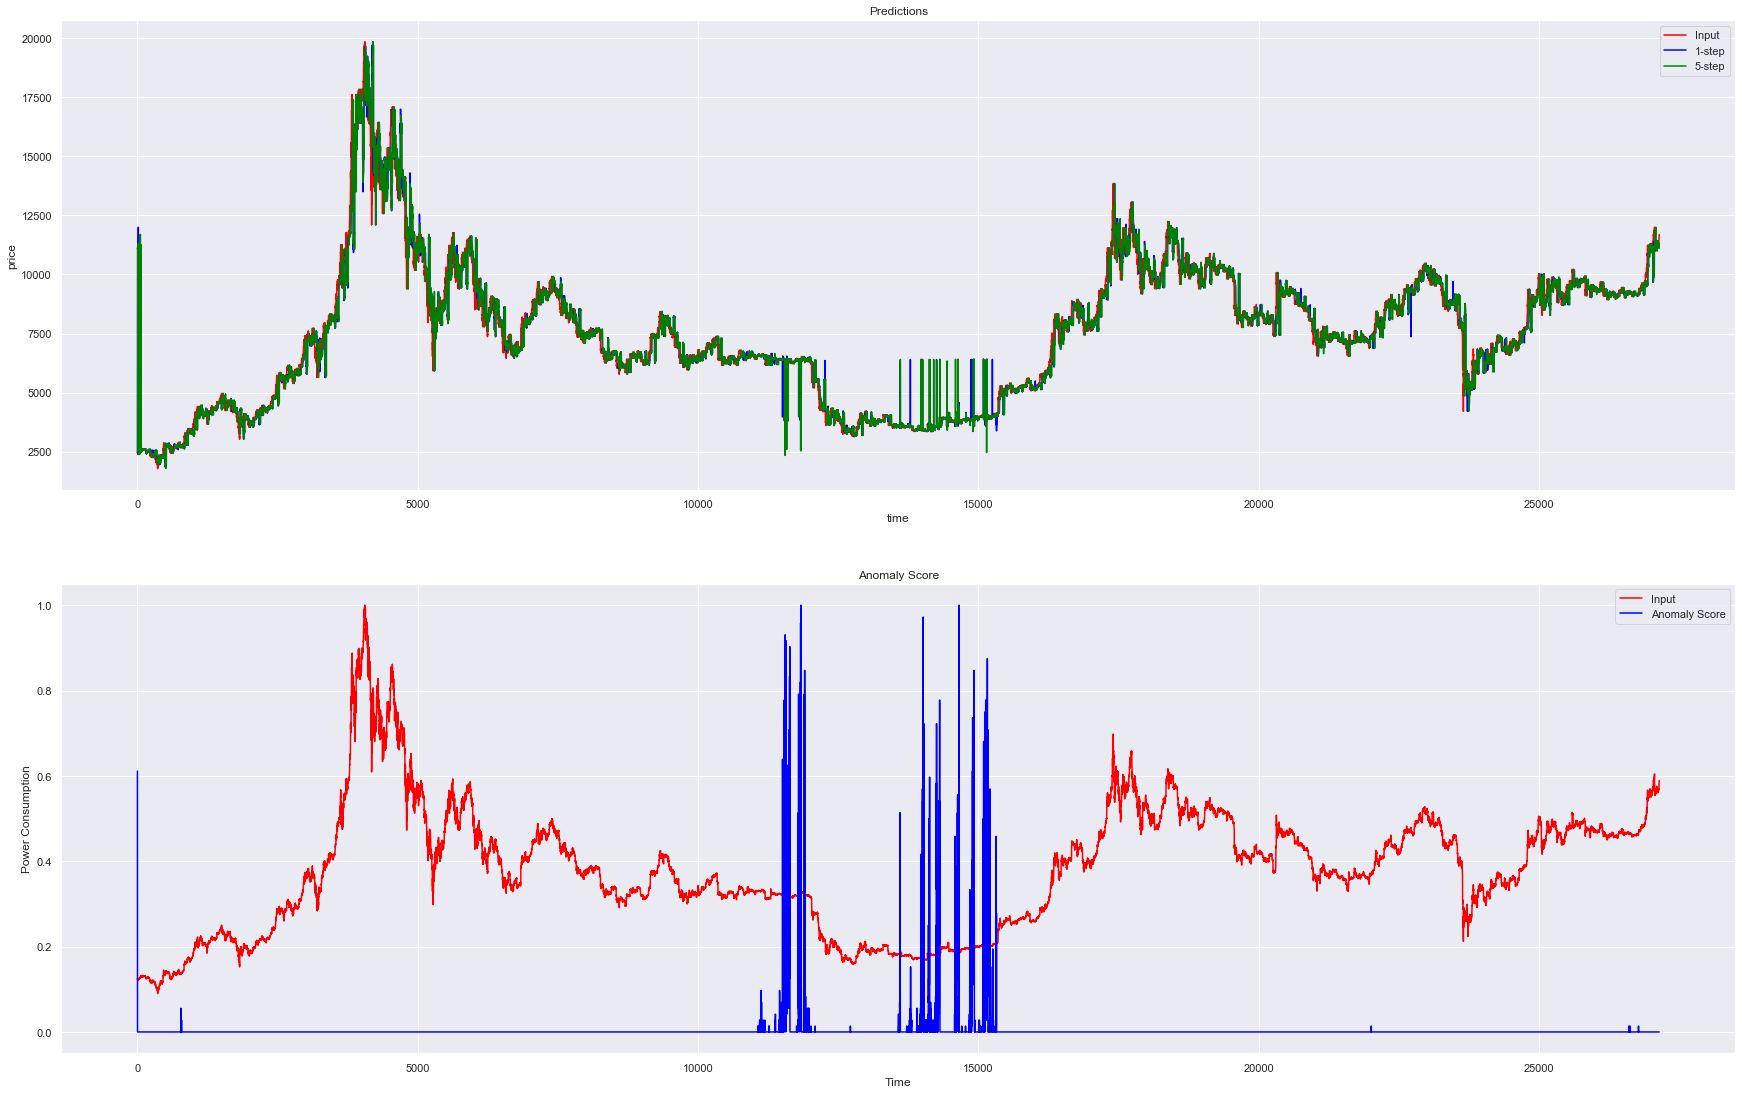

In [44]:
inputs = list(df['close'])

plt.subplot(2,1,1)

sns.set(rc={'figure.figsize':(30,19)})

plt.title('Predictions')
plt.xlabel('time')
plt.ylabel('price')
plt.plot(np.arange(len(inputs)), inputs, 'red',
        np.arange(len(inputs)), predictions[1], 'blue',
        np.arange(len(inputs)), predictions[5], 'green',)
plt.legend(labels=('Input', '1-step', '5-step'))

plt.subplot(2,1,2)
plt.title("Anomaly Score")
plt.xlabel("Time")
plt.ylabel("Power Consumption")
anom_inputs = np.array(inputs) / max(inputs) # normalize
plt.plot(np.arange(len(anom_inputs)), anom_inputs, 'red',
       np.arange(len(anom_inputs)), anomaly, 'blue',)
plt.legend(labels=('Input', 'Anomaly Score'))
plt.show()

## create function to investigate smaller time-span of predictions
- better visualization than hourly 3-year period

In [41]:
# constructing datetime object for 4/30/16 3:20:06
dt = datetime.datetime(2018,4, 30,0, 20,6) # yr, month, day, hour, min, sec
dt

dates = list(df['date'])
t = dates[0]

print(dt)
print(t)

t > dt

2018-04-30 00:20:06
2020-08-05 15:00:00


True

timestamp objects are compatible with datetime, nice

wait, did i train it chronologically backwards?
what's the... i did, didn't i?

In [78]:
df.iloc[0]['date']

Timestamp('2020-08-05 15:00:00')

In [25]:
predictions[1][20]

11282

In [28]:
# start = df.iloc[20]['date'] 
# end = df.iloc[120]['date']


# mask = (df['date'] >= start) & (df['date'] <= end)
# sub = df.loc[mask]
# inds = list(sub.index) # first index is index of prediction
# start_ind = inds[0]
# end_ind = inds[-1]

# sub_preds = {}
# sub_preds[1] = predictions[1][start_ind:end_ind]
# sub_preds[5] = predictions[5][start_ind:end_ind]
# sub_preds[1][0]

11282

In [29]:
# df.iloc[-1]['date']

Timestamp('2020-08-05 15:00:00')

In [45]:
def subset_timespan(df, predictions, start, end): # returns time-subset df + predictions
    # df & predictions dictionary (one list for 1 and 5 each).
    # start and end timestamps, dateTime or Timestamp format
#     start = df.iloc[20]['date'] 
#     end = df.iloc[120]['date']
    # mask to find dates "in between"
    mask = (df['date'] >= start) & (df['date'] <= end)
    sub = df.loc[mask]
    # index trickery
    inds = list(sub.index) # preserves the indexes from original DF
    start_ind = inds[0] # lines up, allows selection of matching output predictions
    end_ind = inds[-1]
    # make new subset dictionary with old indices
    sub_preds = {}
    sub_preds[1] = predictions[1][start_ind:end_ind+1]
    sub_preds[5] = predictions[5][start_ind:end_ind+1]
    return sub, sub_preds

# closest data is august 5, so let's try to get all of july
# dt = datetime.datetime(2018,4, 30,0, 20,6) # yr, month, day, hour, min, sec

st = datetime.datetime(2020,7,1, 0,0,0)
en = datetime.datetime(2020,7,31, 23,0,0)
july_df, july_preds = subset_timespan(df, predictions, st, en)

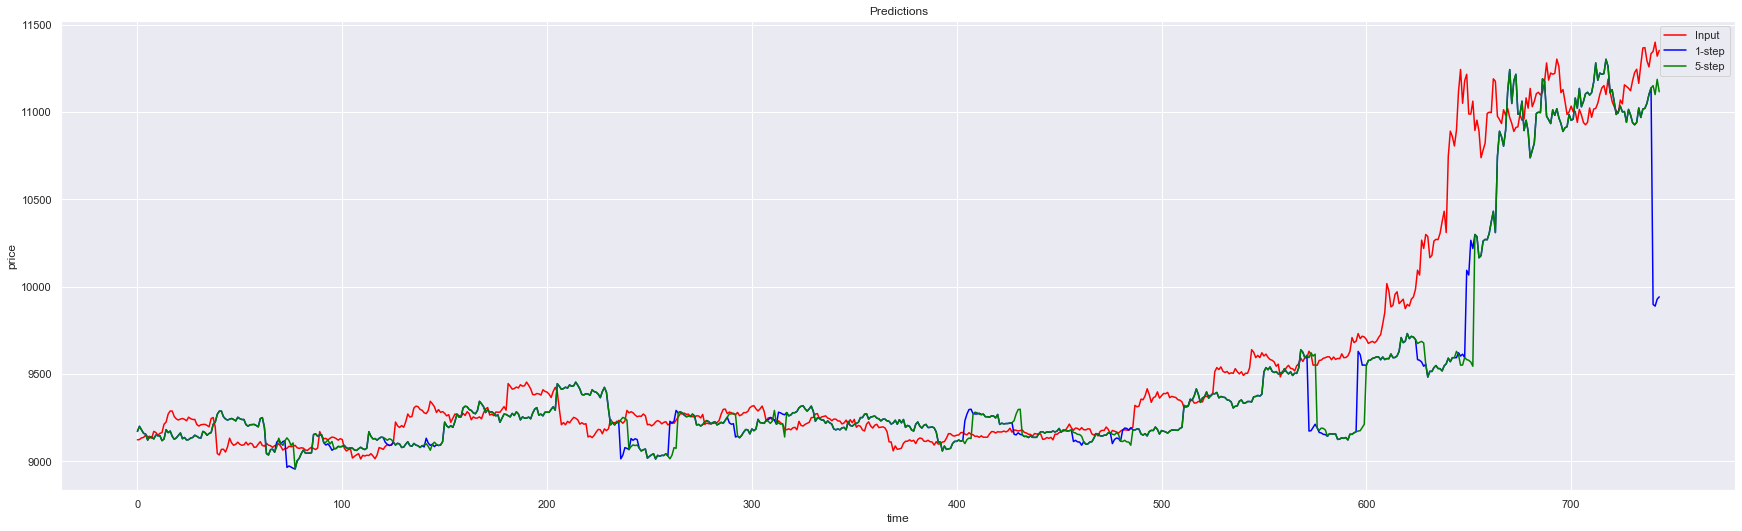

In [46]:
def graph_section(df, predictions):
    inputs = list(df['close'])
    plt.subplot(2,1,1)
    sns.set(rc={'figure.figsize':(30,19)})

    plt.title('Predictions')
    plt.xlabel('time')
    plt.ylabel('price')
    plt.plot(np.arange(len(inputs)), inputs, 'red',
            np.arange(len(inputs)), predictions[1], 'blue',
            np.arange(len(inputs)), predictions[5], 'green',)
    plt.legend(labels=('Input', '1-step', '5-step'))

graph_section(july_df, july_preds)